# **Modèle de Prédiction du Taux de Grippe**

2-levels model : level 0 (global & régionales) et level 1 (meta modèle)

Score 100 sur kaggle 

---------

In [1]:
import pandas as pd
import numpy as np

from catboost import CatBoostRegressor
from catboost import Pool
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot') 
import shap

import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

np.random.seed(42)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Data Importation**

-----

In [ ]:
df_train = pd.read_csv('../data_modelisation/train_full.csv')
df_test = pd.read_csv('../data_modelisation/test_full.csv')

In [ ]:
# Tri chronologique par semaine
df_train = df_train.sort_values('week').reset_index(drop=True)
df_test = df_test.sort_values('week').reset_index(drop=True)

In [6]:
df_train.shape

(9196, 42)

In [7]:
df_test.shape

(2288, 40)

In [10]:
print(f"Train période : {df_train['week'].min()}-{df_train['week'].max()}")
print(f"Test période : {df_test['week'].min()}-{df_test['week'].max()}")

Train période : 200401-201152
Test période : 201201-201352


## **Feature Engineering**

-------------


In [65]:
def feature_eng(df, donnees_historiques):
    """
    Preprocessing fonction
    """
    df = df.copy()
    hist = donnees_historiques.copy()
    
    # ===VARIABLES TEMPORELLES===
    df['annee'] = df['week'].astype(str).str[:4].astype(int)
    df['week_num'] = df['week'].astype(str).str[4:].astype(int)
    hist['annee'] = hist['week'].astype(str).str[:4].astype(int)
    hist['week_num'] = hist['week'].astype(str).str[4:].astype(int)
    
    # Harmoniques de Fourier pour capture la saisonnalité annuelle, 1/2/3 ycles par an
    for k in [1, 2, 3]:
        df[f'sin_{k}'] = np.sin(2 * np.pi * k * df['week_num'] / 52)
        df[f'cos_{k}'] = np.cos(2 * np.pi * k * df['week_num'] / 52)
    
    # -----------------VARIABLES TEMPORELLES-----------------
    # ===PHASES D'EPIDEMIE===
    # Phase montante du grippe passe en décembre (week 48-52 +- 1-3) 
    df['est_phase_montante'] = df['week_num'].isin(list(range(48, 53))+[1,2,3]).astype(int)
    
    # Pic passe donc en fin janvier (week 4) - début mars (week 9)
    df['est_pic_hivernal'] = df['week_num'].isin([4, 5, 6,7,8]).astype(int)
    
    # Phase se basse en semaines qui nous resteent
    df['est_phase_basse'] = df['week_num'].isin(range(18, 45)).astype(int)
    
    # Distance cyclique vectorisée 
    distance_directe = np.abs(df['week_num']-5)
    distance_circulaire = 52-distance_directe
    df['distance_au_pic'] = np.minimum(distance_directe, distance_circulaire)
    
    # Plus on est loin moins c'est intensif avec la vitesse moyenne de 5
    # exp(0)=1 exp(10)=0,14 
    df['intensite_pic'] = np.exp(-df['distance_au_pic']/5)
    
    df[['distance_au_pic', 'intensite_pic']].hist(bins=30, figsize=(11, 5))
    plt.tight_layout()
    plt.show()


    # ===VARIABLES DE CROISEMENT===
    # Agrégation par région et week_num
    agg_region_semaine = (hist
                          .groupby(['region_code', 'week_num'])['TauxGrippe']
                          .agg(
                              rs_moyenne='mean',
                              rs_ecart_type='std',
                              rs_mediane='median',
                              rs_q25=lambda x: x.quantile(0.25),
                              rs_q75=lambda x: x.quantile(0.75))
                              .reset_index())
    
    agg_region_semaine.columns = ['region_code', 'week_num', 'rs_moyenne', 'rs_ecart_type', 'rs_mediane', 'rs_q25', 'rs_q75']
    df = df.merge(agg_region_semaine, on=['region_code', 'week_num'], how='left')
    
    # Agrégation par week_num
    agg_semaine = hist.groupby('week_num')['TauxGrippe'].agg(['mean', 'std', 'median']).reset_index()
    agg_semaine.columns = ['week_num', 's_moyenne', 's_ecart_type', 's_mediane']
    df = df.merge(agg_semaine, on='week_num', how='left')
    
    # Agrégation par région
    agg_region = hist.groupby('region_code')['TauxGrippe'].agg(['mean', 'std']).reset_index()
    agg_region.columns = ['region_code', 'r_moyenne', 'r_ecart_type']
    df = df.merge(agg_region, on='region_code', how='left')
    
    df.fillna(df.median(numeric_only=True), inplace=True)
    
    # ===LES IQRs===
    # ÉSi petit => stabilité du tx de grippe chaque an, si grand => instabilité
    df['rs_eiq']=df['rs_q75']-df['rs_q25']

    # Ratio région/national
    df['rs_vs_s']=df['rs_moyenne']/(df['s_moyenne']) 



    # -----------------VARIABLES METEO-----------------
    if 't' in df.columns:
        df['t'] = df['t'].fillna(df['t'].median())
        # Indice de froid à partir de 8 degré
        df['froid'] = np.clip(8-df['t'], 0, None)

    #if 'rr1' in df.columns:
    #    df['rr1'] = df['rr1'].fillna(0)



    # # -----------------VARIABLES DEMOGRAPHIE-----------------
    # ===GOOGLE REQUETES===
    colonnes_google = [
        'requete_grippe',
        'requete_grippe_aviaire_vaccin',
        'requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie'
    ]
    
    df[colonnes_google] = df[colonnes_google].fillna(0)
    
    # Transformation log pour stabiliser
    col_principal_google='requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie'
    if col_principal_google in df.columns:
        df['google_log']=np.log1p(df[col_principal_google])
        moyenne_google = hist[col_principal_google].mean()
        df['google_anomalie'] = df[col_principal_google]/(moyenne_google)
        
        # ===VARIABLES DE CROISEMENT===
        df['google_rs'] = df['google_log']*df['rs_moyenne']
        df['google_s'] = df['google_log']*df['s_moyenne']
        df['google_anom_rs'] = df['google_anomalie']*df['rs_moyenne']
    
    df['region_encodee'] = pd.factorize(df['region_code'])[0]
    
    return df

# L'année 2009 contient des valeurs extremes dues à la pandémie H1N1, test sans l'année 2009 peut  
# mais on risque de perdre la séquence temporelle + augmente notre rmse sur submission
# df_train = df_train[df_train['annee'] != 2009].reset_index(drop=True)

Création des features supplémentaires :  
- variables pour capturer la saisonnalité (les pics, monte et la baisse ; la distance syclique)
- statistiques agrégées par région et par semaine pour les données meteo et démographie
- indice de froid
- variables de croisement
- encodage de la région

## **Data Split**

-------

In [23]:
# Train/val séparation (80/20)
split = int(len(df_train)*0.80)
donnees_train = df_train.iloc[:split].copy()
donnees_val = df_train.iloc[split:].copy()

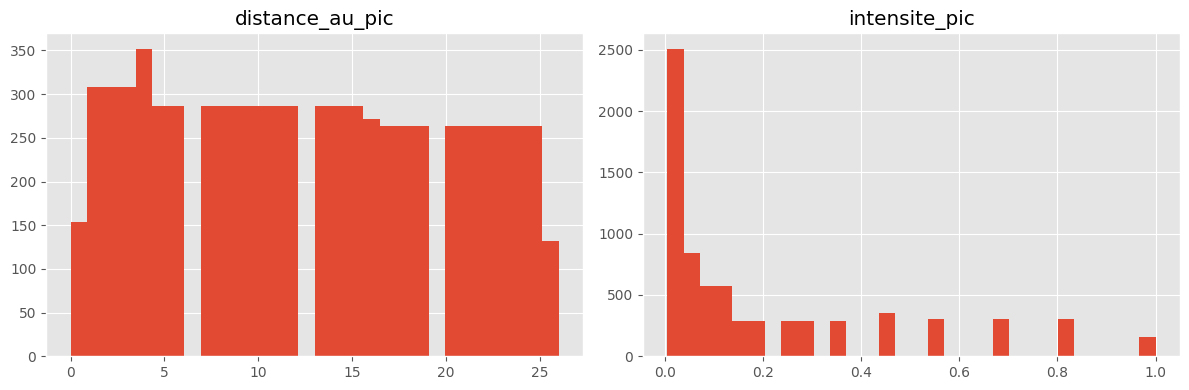

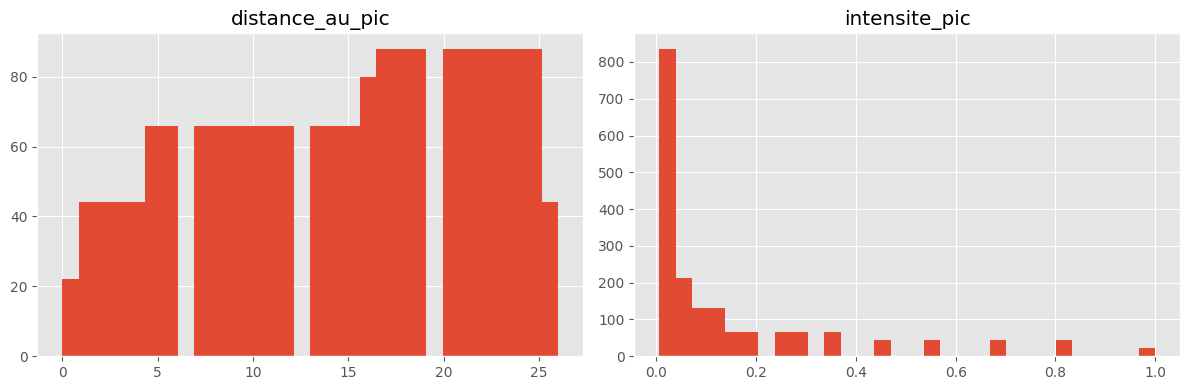

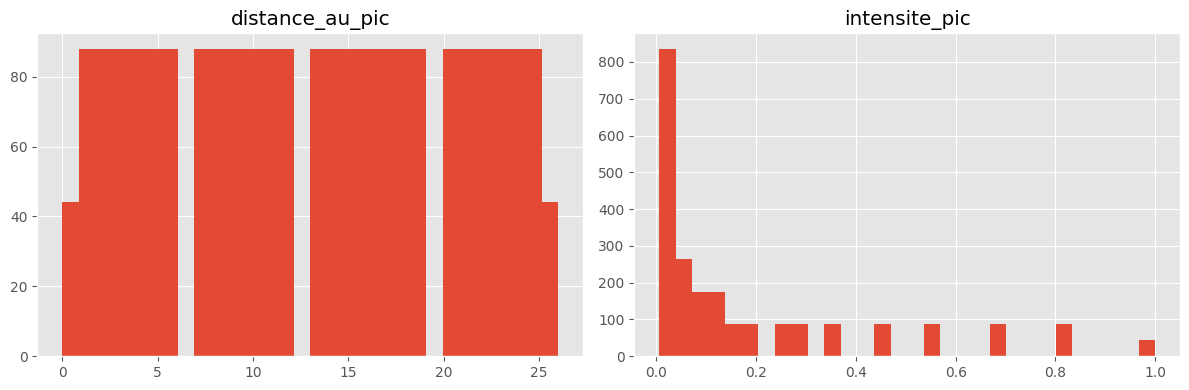

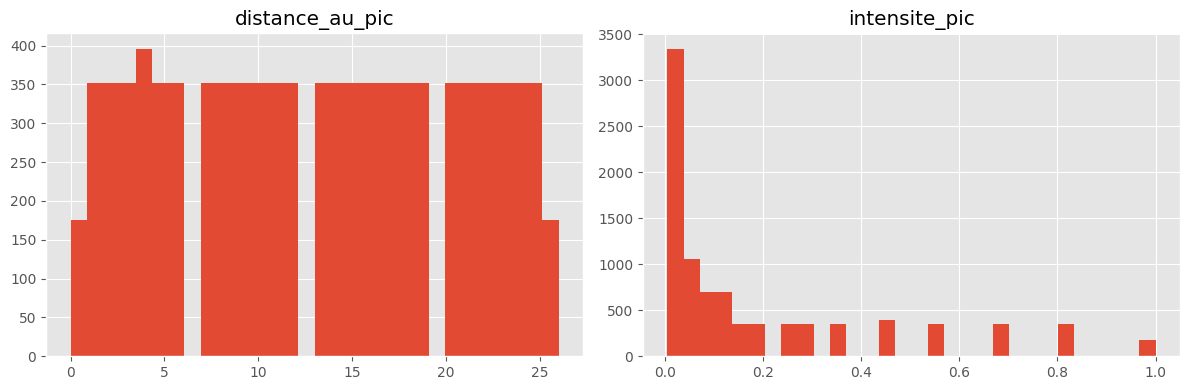

Nb des features : 63
['tend', 'dd', 'ff', 't', 'td', 'u', 'vv', 'n', 'nbas', 'hbas', 'pres', 'tn12', 'tx12', 'tminsol', 'rafper', 'per', 'ht_neige', 'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'pop_0_19', 'pop_20_39', 'pop_40_59', 'pop_60_74', 'pop_75_plus', 'pop_total', 'requete_grippe_aviaire_vaccin', 'requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie', 'week_num', 'sin_1', 'cos_1', 'sin_2', 'cos_2', 'sin_3', 'cos_3', 'est_phase_montante', 'est_pic_hivernal', 'est_phase_basse', 'distance_au_pic', 'intensite_pic', 'rs_moyenne', 'rs_ecart_type', 'rs_mediane', 'rs_q25', 'rs_q75', 's_moyenne', 's_ecart_type', 's_mediane', 'r_moyenne', 'r_ecart_type', 'rs_eiq', 'rs_vs_s', 'froid', 'google_log', 'google_anomalie', 'google_rs', 'google_s', 'google_anom_rs', 'region_encodee']


In [24]:
# Application de l'ingénierie des caractéristiques
caract_train = feature_eng(donnees_train, donnees_train)
caract_val = feature_eng(donnees_val, donnees_train)
caract_test = feature_eng(df_test, df_train)
caract_complet = feature_eng(df_train, df_train)

variables_exclues = ['Id', 'Id_google',
                     'week', 'mois', 'annee', 
                     'TauxGrippe', 'TauxGrippe_google',
                     'region_name', 'region_code', 'franche_comte_impute', 'requete_grippe'
                     ]

features = []

for col in caract_train.columns:
    if col not in variables_exclues:
        if caract_train[col].dtype in ['float64', 'int64']:
            features.append(col)

print(f"Nb des features : {len(features)}")
print(features)



On observe que la distance au pic est répartie de façon assez homogène sur l’année, tandis que l’intensité du pic est fortement concentrée près de zéro (0-0,05).

- La saisonnalité normale - peu de semaines proches du pic et beaucoup de semaines avec une intensité faible.

- Features : 'tend', 'dd', 'ff', 't', 'td', 'u', 'vv', 'n', 'nbas', 'hbas', 'pres', 'tn12', 'tx12', 'tminsol', 'rafper', 'per', 'ht_neige', 'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'pop_0_19', 'pop_20_39', 'pop_40_59', 'pop_60_74', 'pop_75_plus', 'pop_total', 'requete_grippe_aviaire_vaccin', 'requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie', 'week_num', 'sin_1', 'cos_1', 'sin_2', 'cos_2', 'sin_3', 'cos_3', 'est_phase_montante', 'est_pic_hivernal', 'est_phase_basse', 'distance_au_pic', 'intensite_pic', 'rs_moyenne', 'rs_ecart_type', 'rs_mediane', 'rs_q25', 'rs_q75', 's_moyenne', 's_ecart_type', 's_mediane', 'r_moyenne', 'r_ecart_type', 'rs_eiq', 'rs_vs_s', 'froid', 'google_log', 'google_anomalie', 'google_rs', 'google_s', 'google_anom_rs', 'region_encodee'.

In [ ]:
# Data prep train/val/test
X_train = caract_train[features+['region_code']]
y_train = caract_train['TauxGrippe']
X_val = caract_val[features + ['region_code']]
y_val = caract_val['TauxGrippe']
X_complet = caract_complet[features + ['region_code']]
y_complet = caract_complet['TauxGrippe']
X_test = caract_test[features + ['region_code']]

### **Matrice de corrélation pour des nouveaux features**


In [30]:
# Sélection des 15 variables les plus corrélées avec tx de grippe
correlations = caract_train[features+['TauxGrippe']].corr()['TauxGrippe'].abs()
top_variables = correlations.nlargest(15).index.tolist() 
top_variables.remove('TauxGrippe')

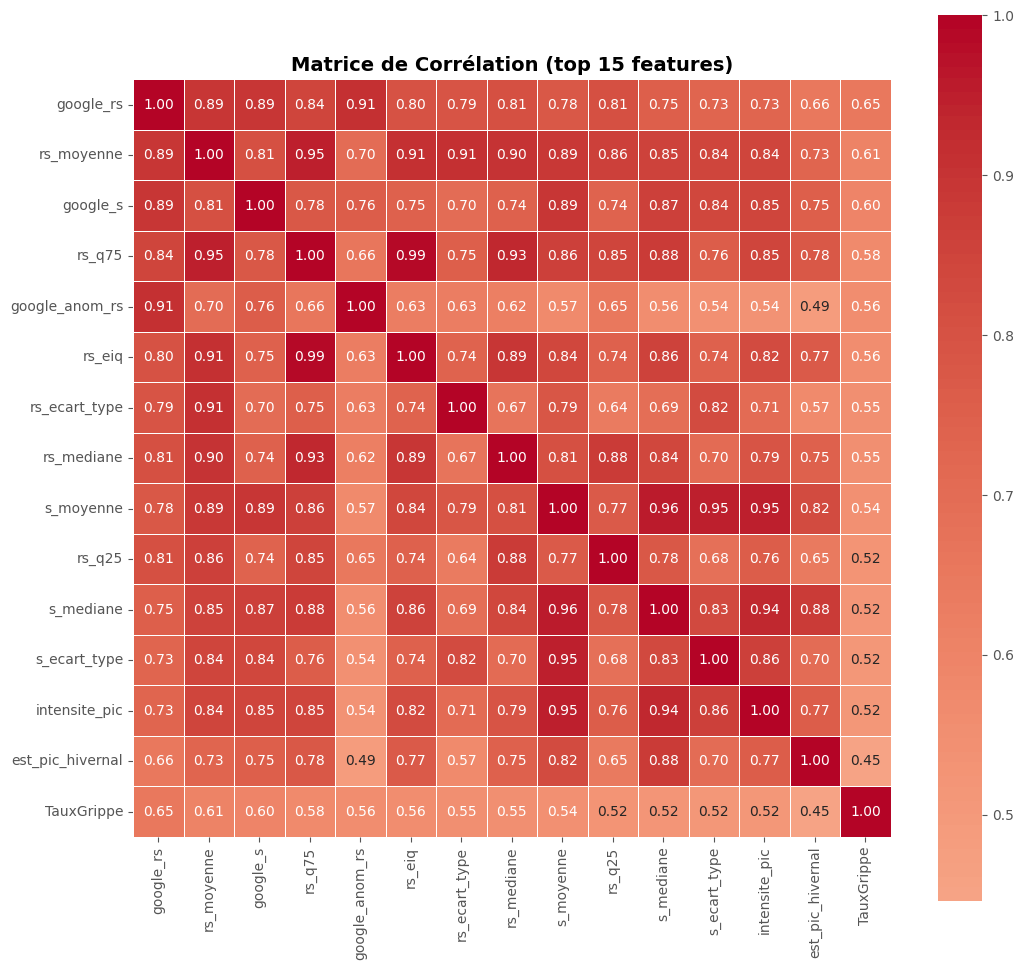

Features les plus corrélées avec TauxGrippe :
google_rs : 0.6549191755590246
rs_moyenne : 0.6101421616955757
google_s : 0.600755229868
rs_q75 : 0.5767138992626283
google_anom_rs : 0.558816652460638
rs_eiq : 0.5567978009524531
rs_ecart_type : 0.5549389748016192
rs_mediane : 0.5482860310127378
s_moyenne : 0.54207407664194
rs_q25 : 0.5246686838527702
s_mediane : 0.5194983519509269
s_ecart_type : 0.515554053388111
intensite_pic : 0.515285890001135
est_pic_hivernal : 0.44606944580114355


In [64]:
matrice_corr = caract_train[top_variables+['TauxGrippe']].corr()

plt.figure(figsize=(11, 10))
sns.heatmap(
    matrice_corr, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    center=0,
    square=True,
    linewidths=0.5
)
plt.title('Matrice de Corrélation (top 15 features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Features les plus corrélées avec TauxGrippe :")
for i, var in enumerate(top_variables[:15], 1):
    corr_val = correlations[var]
    print(f"{var} : {corr_val}")

On verra sur le plot d'importance si ces variables contribuent le plus au modèle.

## **Stacked Generalization**

---------

## **Level 0 : Base Models - Modèle Global**

Principe : 
- Hyperparamètres optimisés avec **Optuna** 
- Un seul modèle CatBoost entraîné sur **toutes les régions** 
- Capture les tendances **nationales** et patterns communs mais capture pas les spécificités régionales

### **Optimisation des hyperparamètres avec Optuna**


In [32]:
def calculer_rmse(y_reel, y_predit):
    return np.sqrt(mean_squared_error(y_reel, y_predit))

In [33]:
def opt_hp(trial):
    # Hyperparamètres à optimiser
    params = {
        'iterations': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 3, 6),  # Peu profond = conservateur
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5.0, 25.0),  # Forte régularisation
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 30, 100),
        'random_strength': trial.suggest_float('random_strength', 1.0, 3.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.5, 1.5),
        'border_count': 64,
        'random_seed': 42,
        'verbose': 0,
        'early_stopping_rounds': 100,
        'use_best_model': True
    }
    
    # Entrainement sur CATB
    modele = CatBoostRegressor(**params)
    pool_train = Pool(X_train, y_train, cat_features=['region_code'])
    pool_val = Pool(X_val, y_val, cat_features=['region_code'])
    modele.fit(pool_train, eval_set=pool_val)
    
    predictions = np.clip(modele.predict(X_val), 0, None)
    score_rmse = calculer_rmse(y_val, predictions)
    
    return score_rmse

In [44]:
# Création de l'étude Optuna
etude_globale = optuna.create_study(
    direction='minimize',
    study_name='modele_global',
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)

# Optimisation (30 trials)
etude_globale.optimize(opt_hp, n_trials=30, show_progress_bar=True)
best_params_global = etude_globale.best_params
best_score_global = etude_globale.best_value

print(f"Meilleur RMSE : {best_score_global:.2f}")
print(f"Meilleurs hyperparamètres :")
for param, valeur in best_params_global.items():
    print(f"{param} : {valeur}")

Best trial: 13. Best value: 93.1186: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]

Meilleur RMSE : 93.12
Meilleurs hyperparamètres :
learning_rate : 0.09757384734371255
depth : 6
l2_leaf_reg : 5.396225694753878
min_data_in_leaf : 100
random_strength : 2.6566810073775122
bagging_temperature : 0.5356338697938183


In [ ]:
# Entraînement du modèle avec les meilleurs paramètres
params_finaux_global = {
    'iterations': 2000,
    'early_stopping_rounds': 100,
    'use_best_model': True,
    'border_count': 64,
    'random_seed': 42,
    'verbose': 0,
    **best_params_global
}

modele_global_optimal = CatBoostRegressor(**params_finaux_global)
pool_train = Pool(X_train, y_train, cat_features=['region_code'])
pool_val = Pool(X_val, y_val, cat_features=['region_code'])
modele_global_optimal.fit(pool_train, eval_set=pool_val)

### **Modèles par Région**

- Création de 22 modèles chaque par région afin de capturer les spécificités locales


In [37]:
liste_regions = df_train['region_code'].unique()
predictions_regionales_val = np.zeros(len(caract_val))
modeles_regionaux = {}

config_regionale = {
    'iterations': 500,
    'learning_rate': 0.05,
    'depth': 4,
    'l2_leaf_reg': 15.0,
    'min_data_in_leaf': 20,
    'random_strength': 2.0,
    'bagging_temperature': 1.0,
    'random_seed': 42,
    'verbose': 0,
    'early_stopping_rounds': 50,
    'use_best_model': True
}

In [40]:
for region in sorted(liste_regions):
    # Filtrage par région
    mask_tr = caract_train['region_code'] == region
    mask_va = caract_val['region_code'] == region

    X_tr = caract_train.loc[mask_tr, features]
    y_tr = caract_train.loc[mask_tr, 'TauxGrippe']
    X_va = caract_val.loc[mask_va, features]
    y_va = caract_val.loc[mask_va, 'TauxGrippe']

    model = CatBoostRegressor(**config_regionale)

    if not X_va.empty:
        model.fit(X_tr, y_tr, eval_set=(X_va, y_va))
        preds = np.clip(model.predict(X_va), 0, None)
        predictions_regionales_val[mask_va] = preds
        rmse = calculer_rmse(y_va, preds)
    else:
        model.fit(X_tr, y_tr)
        rmse = np.nan

    modeles_regionaux[region] = model
    print(f"Région {region:2d} : RMSE = {rmse}")

# Score global des modèles régionaux
rmse_regional_global = calculer_rmse(y_val, predictions_regionales_val)
print(f"RMSE régional global : {rmse_regional_global}")


Région 11 : RMSE = 68.44081219319524
Région 21 : RMSE = 66.58134771772492
Région 22 : RMSE = 55.288373187669904
Région 23 : RMSE = 44.24336943535909
Région 24 : RMSE = 85.0690925054327
Région 25 : RMSE = 94.76878420010273
Région 26 : RMSE = 39.76021792309714
Région 31 : RMSE = 215.08075549018153
Région 41 : RMSE = 40.52503702197192
Région 42 : RMSE = 51.415963215926425
Région 43 : RMSE = 60.32730209871699
Région 52 : RMSE = 64.02904890777054
Région 53 : RMSE = 63.20114018927738
Région 54 : RMSE = 105.85371470626482
Région 72 : RMSE = 30.625944039584898
Région 73 : RMSE = 56.998492388054416
Région 74 : RMSE = 152.6912572327797
Région 82 : RMSE = 43.423108884154
Région 83 : RMSE = 57.46317397918651
Région 91 : RMSE = 64.63368686305142
Région 93 : RMSE = 40.337012070014524
Région 94 : RMSE = 160.41725012148177
RMSE régional global : 87.83471823661047


## **Level 1 : Meta Model**

Principe :
- Combinaison des prédictions Level 0 (par moyenne ponderée)
- Capture le modèle global (nationale) + les modèles régionaux


In [50]:
# Prédictions du modèle global sur validation
predictions_globales_val = np.clip(modele_global_optimal.predict(X_val), 0, None)

# Recherche du meilleur poids pour la combinaison entre globale et régionale 
best_poids = 0.5
best_rmse_stack = float('inf')
resultats_stacking = []

for poids in np.arange(0.0, 1.05, 0.05):
    # Combinaison pondérée
    poids_stack = poids * predictions_regionales_val+(1-poids)*predictions_globales_val
    score = calculer_rmse(y_val, poids_stack)
    resultats_stacking.append((poids, score))
    
    if score<best_rmse_stack:
        best_rmse_stack = score
        best_poids = poids


print(f"Modèle Global : {best_score_global}")
print(f"Modèles Régionaux : {rmse_regional_global}")
print(f"Meta Modèle: {best_rmse_stack}")
print(f"Poids optimal : {best_poids:}")

Modèle Global : 93.11861412103165
Modèles Régionaux : 87.83471823661047
Meta Modèle: 87.81806953217855
Poids optimal : 0.9500000000000001


Gain du stacking : -0.016648704431915462 RMSE (0.0%)


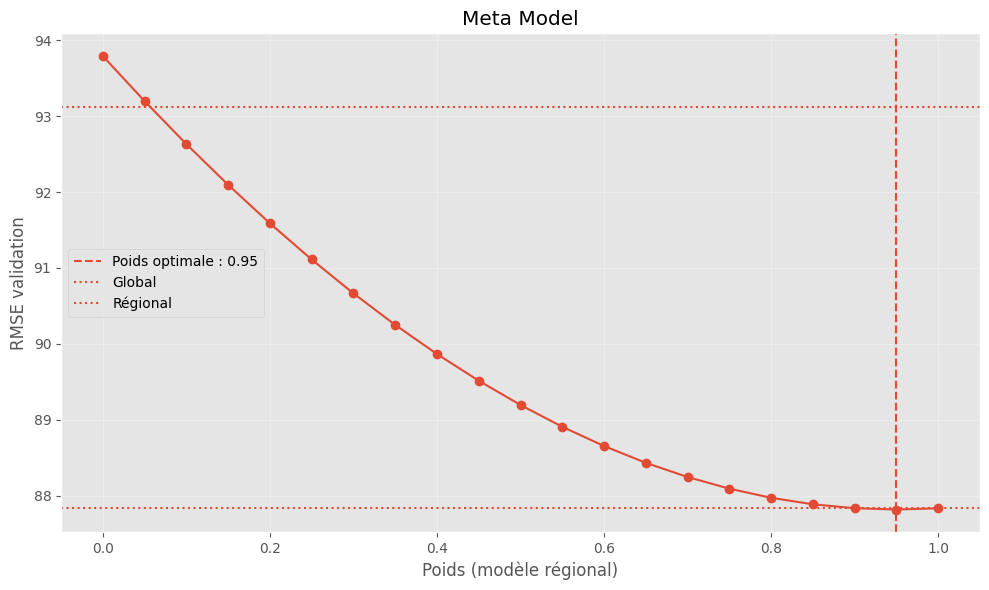

In [67]:
# Gain par rapport aux modèles individuel
best_individuel = min(best_score_global, rmse_regional_global)
gain = best_individuel - best_rmse_stack
gain_poercentage = 100 * gain/ best_individuel
print(f"Gain du stacking : -{gain} RMSE ({gain_poercentage:.1f}%)")

poids, scores = zip(*resultats_stacking)

plt.figure(figsize=(10, 6))
plt.plot(poids, scores, marker='o')
plt.axvline(best_poids, linestyle='--', label=f'Poids optimale : {best_poids:.2f}')
plt.axhline(best_score_global, linestyle=':', label='Global')
plt.axhline(rmse_regional_global, linestyle=':', label='Régional')

plt.xlabel('Poids (modèle régional)')
plt.ylabel('RMSE validation')
plt.title('Meta Model')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Le graphique montre que les modèles régionaux sont bien plus performants que le modèle global (87,9 vs 93,7 RMSE). 

Le blending optimal utilise 95% des prédictions régionales et seulement 5% des globales ce qui permet d'atteindre 87,8 RMSE - légèrement meilleur que les modèles régionaux seuls.

## **SHAP Values**


--------


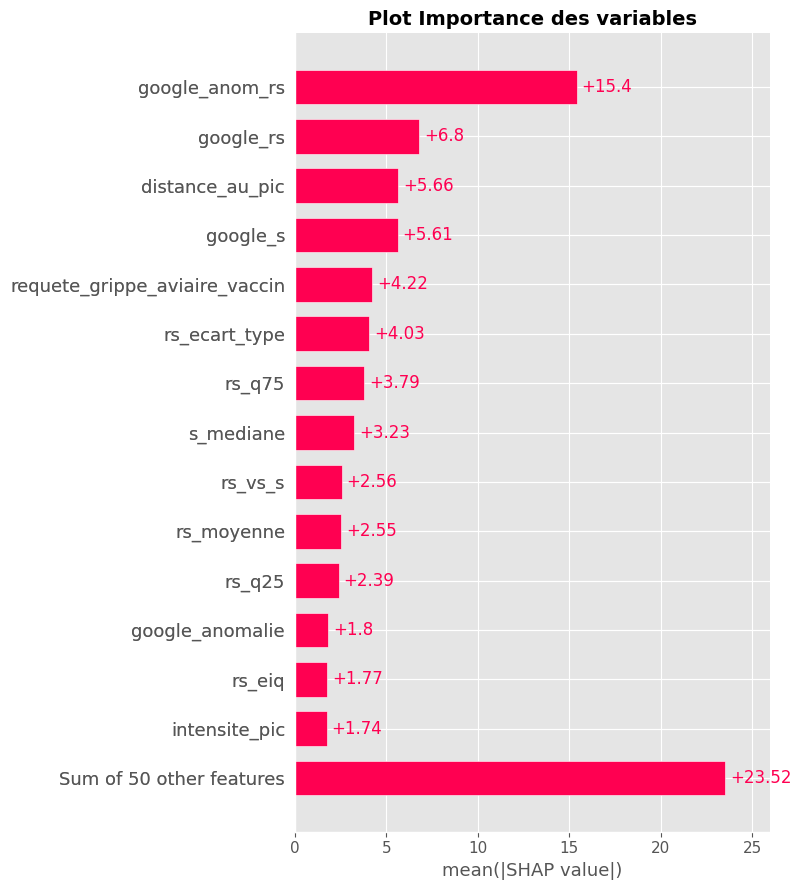

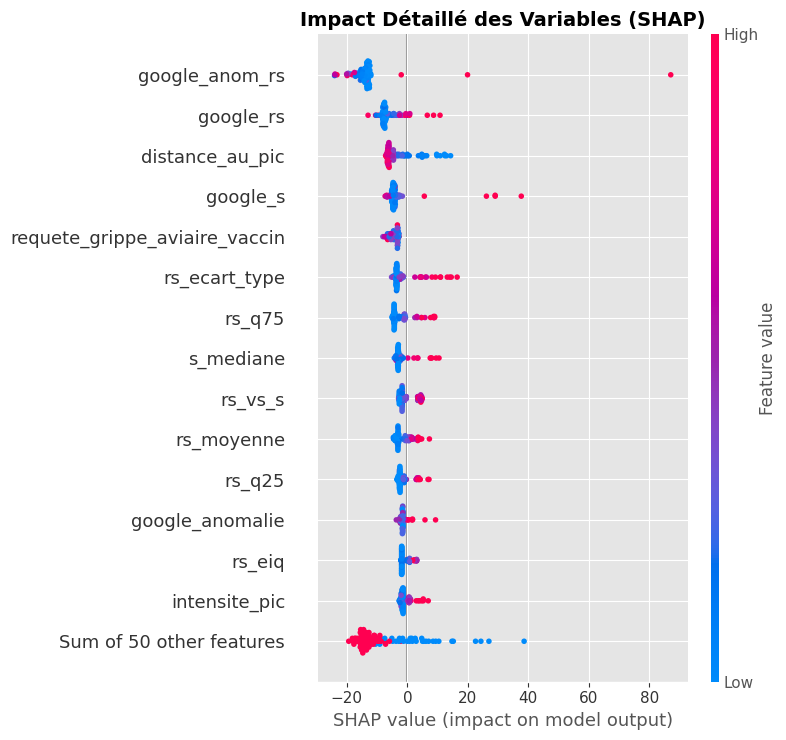

In [68]:
# Échantillonnage pour accélérer le calcul
echantillon_indices = np.random.choice(len(X_val), size=min(100, len(X_val)), replace=False)
X_val_echantillon = X_val.iloc[echantillon_indices]

# Pool Catb avec region_code comme catégorielle
pool_shap = Pool(X_val_echantillon[features+['region_code']], cat_features=['region_code'])
shap_values = modele_global_optimal.get_feature_importance(data=pool_shap, type='ShapValues')

# Dernière colonne=valeur de base
shap_base_value = shap_values[:, -1]
shap_values_matrix = shap_values[:, :-1]

shap_explanation = shap.Explanation(
    values=shap_values_matrix,
    base_values=shap_base_value,
    data=X_val_echantillon[features+['region_code']].values,
    feature_names=features+['region_code'])


plt.figure(figsize=(10, 7))
shap.plots.bar(shap_explanation, max_display=15, show=False)
plt.title('Plot Importance des variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_explanation, max_display=15, show=False)
plt.title('Impact Détaillé des Variables (SHAP)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Features les plus corrélées avec TauxGrippe**
- google_rs -> top 10 des plus importantes 
- rs_moyenne -> top 10 des plus importantes 
- google_s -> top 10 des plus importantes 
- rs_q75 -> top 10 des plus importantes 
- google_anom_rs -> top 10 des plus importantes 
- rs_eiq 
- rs_ecart_type -> top 10 des plus importantes 
- rs_mediane -> top 10 des plus importantes 
- s_moyenne -> top 10 des plus importantes 
- rs_q25 -> top 10 des plus importantes 
- s_mediane -> top 10 des plus importantes 
- s_ecart_type 
- intensite_pic -> top 10 des plus importantes 
- est_pic_hivernal.



Google requetes est le prédicteur le plus puissant : les recherches massives signalent une épidémie en temps réel. La proximité de l'hiver (février = pic) augmente aussi fortement les prédictions.

## **Prédictions Finales sur le Test**


------


In [ ]:
params_finaux_global.update(iterations=modele_global_optimal.get_best_iteration() + 50) # buffer pour early stop
params_finaux_global.pop('early_stopping_rounds', None)
params_finaux_global.pop('use_best_model', None)

modele_global_final = CatBoostRegressor(**params_finaux_global)
modele_global_final.fit(Pool(X_complet, y_complet, cat_features=['region_code']))

predictions_globales_test = np.clip(modele_global_final.predict(X_test), 0, None)


predictions_regionales_test = np.zeros(len(caract_test))

for region in sorted(liste_regions):
    mask_c = caract_complet['region_code'] == region
    mask_t = caract_test['region_code'] == region

    if not mask_t.any():
        continue

    config = config_regionale.copy()
    config.update(
        iterations=modeles_regionaux[region].get_best_iteration() + 30)
    config.pop('early_stopping_rounds', None)
    config.pop('use_best_model', None)

    model = CatBoostRegressor(**config)
    model.fit(
        caract_complet.loc[mask_c, features],
        caract_complet.loc[mask_c, 'TauxGrippe']
    )

    predictions_regionales_test[mask_t] = np.clip(model.predict(caract_test.loc[mask_t, features]), 0, None)

predictions_stack_test = (best_poids*predictions_regionales_test+(1 - best_poids) * predictions_globales_test)

In [74]:
print(f"RESULTATS FINAUX :")
print(f"Modèle Global : {best_score_global:.2f} RMSE")
print(f"Modèles Régionaux : {rmse_regional_global:.2f} RMSE")
print(f"Meta Modèle : {best_rmse_stack:.2f} RMSE")

RESULTATS FINAUX :
Modèle Global : 93.12 RMSE
Modèles Régionaux : 87.83 RMSE
Meta Modèle : 87.82 RMSE


## **CSV Submission**

--------

In [75]:
soumission_globale = pd.DataFrame({'Id': df_test['Id'].astype(int), 'TauxGrippe': predictions_globales_test}).sort_values('Id').reset_index(drop=True)
soumission_regionale = pd.DataFrame({'Id': df_test['Id'].astype(int), 'TauxGrippe': predictions_regionales_test}).sort_values('Id').reset_index(drop=True)
soumission_meta = pd.DataFrame({'Id': df_test['Id'].astype(int), 'TauxGrippe': predictions_globales_test}).sort_values('Id').reset_index(drop=True)

soumission_meta.to_csv('soumission_modele_meta_finale.csv', index=False)